In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import clone
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:

# Define your target dataset path
target_dir = '../../original_dataset'

# Check if the path exists
if os.path.exists(target_dir):
    print(f"The dataset path {target_dir} exists.")
else:
    print(f"The dataset path {target_dir} does not exist.")

The dataset path ../../original_dataset exists.


In [5]:
classes = ['home_office', 'hotel_room', 'church', 'museum', 'supermarket']

def show_target_dir_status(target_dir, classes):
    """
    Show the number of images in each class directory within the target directory.

    """
    print(f"Status of target directory: {target_dir}")
    for cls in classes:
        class_dir = os.path.join(target_dir, cls)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"Class '{cls}' contains {num_images} images.")
        else:
            print(f"Class directory '{cls}' does not exist.")

# Show the status of the target directory
show_target_dir_status(target_dir, classes)

Status of target directory: ../../original_dataset
Class 'home_office' contains 1346 images.
Class 'hotel_room' contains 1524 images.
Class 'church' contains 798 images.
Class 'museum' contains 761 images.
Class 'supermarket' contains 1466 images.


In [33]:
# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load the dataset
# dataset = datasets.ImageFolder(target_dir, transform=transform)

# # Print the mapping of class indices to class names
# print("Class to index mapping:", dataset.class_to_idx)


Class to index mapping: {'church': 0, 'home_office': 1, 'hotel_room': 2, 'museum': 3, 'supermarket': 4}


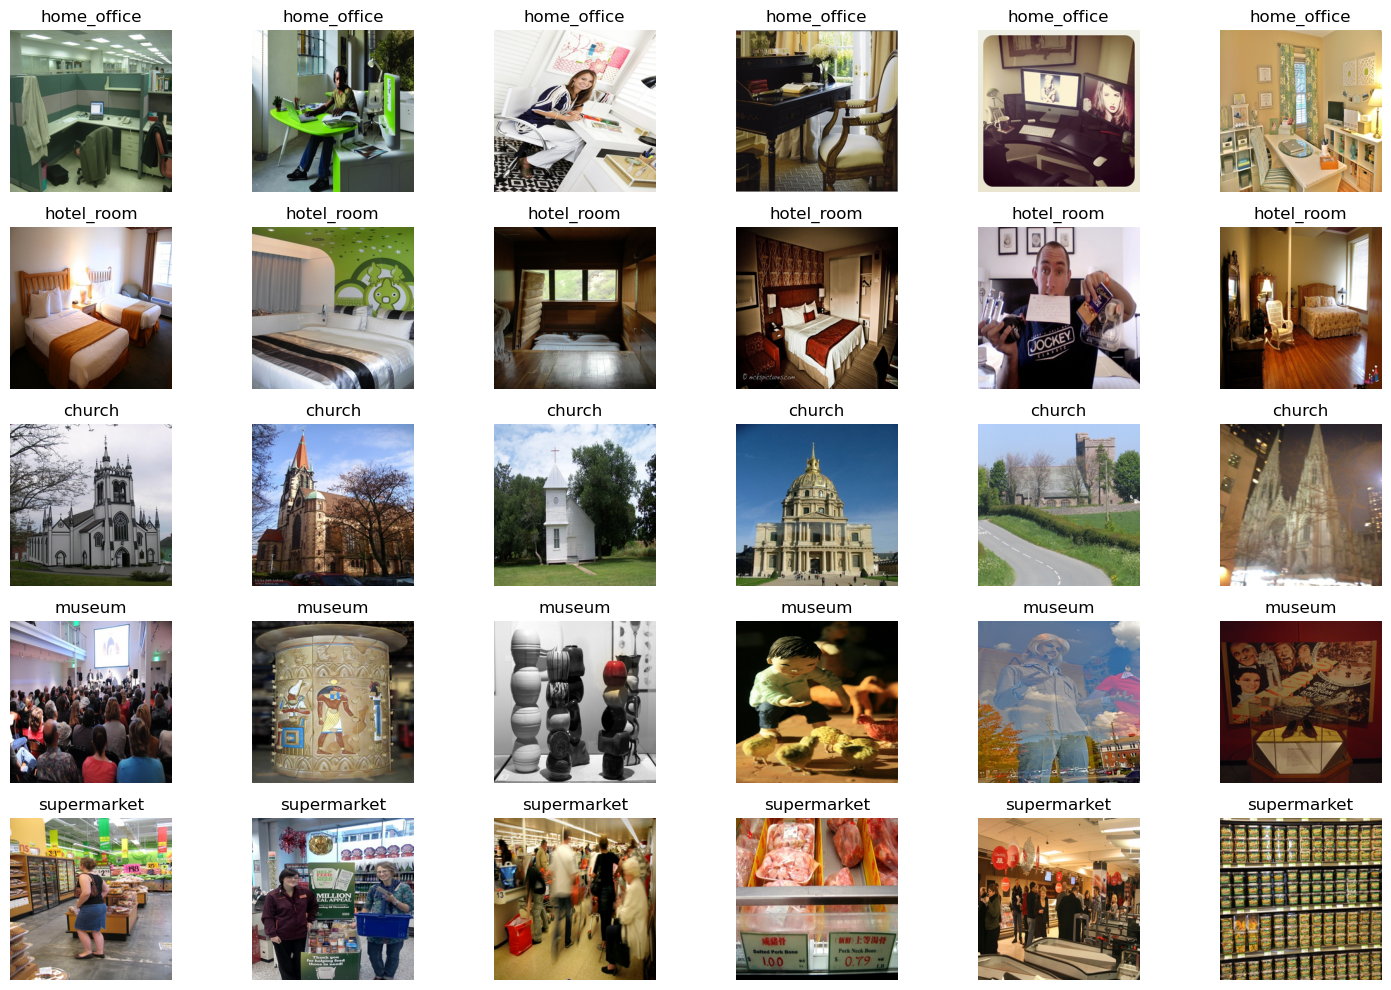

In [6]:
def show_images_with_labels(target_dir, classes, num_images=6):
    """
    Display images with their corresponding labels from the target directory.

    """
    # Create figure and axes
    fig, axes = plt.subplots(len(classes), num_images, figsize=(15, 10))
    
    # Iterate through each class
    for i, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        class_images = os.listdir(class_dir)
        selected_images = np.random.choice(class_images, num_images, replace=False)
        
        # Iterate through selected images for the class
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = plt.imread(img_path)
            
            # Plot the image
            axes[i, j].imshow(img)
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

show_images_with_labels(target_dir, classes)

In [7]:
def is_image_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png')
    return filename.lower().endswith(valid_extensions)

def preprocess_images(target_dir, classes, image_size=(256, 256)):
    X = []
    y = []
    
    for label, cls in enumerate(classes):
        class_dir = os.path.join(target_dir, cls)
        for img_name in os.listdir(class_dir):
            if is_image_file(img_name):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img = img.convert('RGB')  # Ensure image is in RGB mode
                        img = img.resize(image_size)  # Resize image
                        img_array = np.array(img).flatten()  # Flatten the image
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing file {img_path}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    return X, y

# Preprocess labeled images
X_labeled, y_labeled = preprocess_images(target_dir, classes)
print("Labeled image data shape:", X_labeled.shape)
print("Labeled labels shape:", y_labeled.shape)

Labeled image data shape: (5893, 196608)
Labeled labels shape: (5893,)


In [8]:
# Split the labeled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (4714, 196608)
Testing data shape: (1179, 196608)


In [9]:
# Assume a portion of the training data is unlabeled for the purpose of semi-supervised learning
X_train_labeled, X_train_unlabeled, y_train_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_labeled_normalized = scaler.fit_transform(X_train_labeled)
X_train_unlabeled_normalized = scaler.transform(X_train_unlabeled)
X_test_normalized = scaler.transform(X_test)

In [12]:
def self_training(clf, X_train, y_train, X_unlabeled, max_iter=10, confidence_threshold=0.5):
    """
    Self-training algorithm for semi-supervised learning using decision tree.

    Parameters:
    - clf: Classifier to use for training
    - X_train: Labeled training data
    - y_train: Labels for the training data
    - X_unlabeled: Unlabeled data
    - max_iter: Maximum number of self-training iterations
    - confidence_threshold: Minimum confidence threshold to add a predicted label to the training data

    Returns:
    - clf: The trained classifier
    """
    clf = clone(clf)  # Clone the classifier to avoid modifying the original model
    clf.fit(X_train, y_train)
    
    for i in range(max_iter):
        # Predict probabilities for the unlabeled data
        if X_unlabeled.shape[0] == 0:
            print(f"No more unlabeled samples available in iteration {i + 1}. Stopping self-training.")
            break
        
        proba = clf.predict_proba(X_unlabeled)
        confidence = np.max(proba, axis=1)
        pseudo_labels = np.argmax(proba, axis=1)
        
        # Select instances with high confidence
        confident_indices = np.where(confidence >= confidence_threshold)[0]
        
        if len(confident_indices) == 0:
            print(f"No confident predictions found in iteration {i + 1}. Stopping self-training.")
            break
        
        # Add these confident instances to the training set
        X_train = np.vstack([X_train, X_unlabeled[confident_indices]])
        y_train = np.hstack([y_train, pseudo_labels[confident_indices]])
        
        # Remove these instances from the unlabeled set
        X_unlabeled = np.delete(X_unlabeled, confident_indices, axis=0)
        
        # Retrain the classifier with the expanded training set
        clf.fit(X_train, y_train)
        
        print(f"Iteration {i + 1}, added {len(confident_indices)} new labeled instances")

    return clf

In [13]:
# Initialize and train the semi-supervised decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf = self_training(clf, X_train_labeled_normalized, y_train_labeled, X_train_unlabeled_normalized)

# Predict on the test set
y_pred = clf.predict(X_test_normalized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Semi-supervised Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

Iteration 1, added 3772 new labeled instances
No more unlabeled samples available in iteration 2. Stopping self-training.
Semi-supervised Accuracy: 0.30364715860899066
Classification Report:
               precision    recall  f1-score   support

 home_office       0.27      0.22      0.24       269
  hotel_room       0.34      0.36      0.35       305
      church       0.40      0.44      0.42       160
      museum       0.15      0.18      0.17       152
 supermarket       0.33      0.31      0.32       293

    accuracy                           0.30      1179
   macro avg       0.30      0.30      0.30      1179
weighted avg       0.31      0.30      0.30      1179



In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [15]:
# Hyperparameter tuning with Grid Search
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the decision tree classifier
base_clf = DecisionTreeClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(base_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_labeled_normalized, y_train_labeled)

# Best estimator after grid search
best_clf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Apply self-training using the best estimator
clf = self_training(best_clf, X_train_labeled_normalized, y_train_labeled, X_train_unlabeled_normalized)

# Predict on the test set
y_pred = clf.predict(X_test_normalized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Semi-supervised Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Iteration 1, added 927 new labeled instances
Iteration 2, added 227 new labeled instances
Iteration 3, added 105 new labeled instances
Iteration 4, added 23 new labeled instances
Iteration 5, added 51 new labeled instances
Iteration 6, added 27 new labeled instances
Iteration 7, added 25 new labeled instances
No confident predictions found in iteration 8. Stopping self-training.
Semi-supervised Accuracy: 0.29285714285714287
Classification Report:
               precision    recall  f1-score   support

 home_office       0.31      0.26      0.28       140
  hotel_room       0.31      0.38      0.34       140
      church       0.35      0.29      0.32       140
      museum       0.27      0.32      0.29       140
 supermarket       0.23      0.21      0.22       140

    accuracy                           0.29   